## Credit Card Balance

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
save_files = True

In [3]:
df_train = pd.read_csv('input/application_train.csv',index_col='SK_ID_CURR')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 286.2+ MB


In [4]:
# load credit card file
df_card = pd.read_csv('input/credit_card_balance.csv')
df_card.info()
df_card.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
SK_ID_PREV                    int64
SK_ID_CURR                    int64
MONTHS_BALANCE                int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL       int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT          int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS          object
SK_DPD                        int64
SK_DPD_DEF                    int64
dtypes: float64(15), int64(7

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [5]:
df_card[df_card.SK_ID_PREV==2562384].sort_values(by='MONTHS_BALANCE').head(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
1811769,2562384,378907,-48,69186.690,270000,67500.0,67500.0,0.0,0.0,NaN,...,67841.190,67841.190,1.0,1,0.0,0.0,NaN,Active,0,0
2584127,2562384,378907,-47,62727.075,270000,0.0,0.0,0.0,0.0,3498.975,...,63246.825,63246.825,0.0,0,0.0,0.0,1.0,Active,0,0
3284876,2562384,378907,-46,62577.900,270000,0.0,0.0,0.0,0.0,3399.795,...,63082.080,63082.080,0.0,0,0.0,0.0,2.0,Active,0,0
2653597,2562384,378907,-45,61484.400,270000,0.0,0.0,0.0,0.0,3346.695,...,61980.255,61980.255,0.0,0,0.0,0.0,3.0,Active,0,0
1039133,2562384,378907,-44,60736.680,270000,0.0,0.0,0.0,0.0,3291.390,...,61224.345,61224.345,0.0,0,0.0,0.0,4.0,Active,0,0
2021610,2562384,378907,-43,59786.865,270000,0.0,0.0,0.0,0.0,3242.250,...,60267.735,60267.735,0.0,0,0.0,0.0,5.0,Active,0,0
1764744,2562384,378907,-42,58743.675,270000,0.0,0.0,0.0,0.0,3194.190,...,59216.985,59216.985,0.0,0,0.0,0.0,6.0,Active,0,0
2239489,2562384,378907,-41,57725.595,270000,0.0,0.0,0.0,0.0,3141.450,...,58191.525,58191.525,0.0,0,0.0,0.0,7.0,Active,0,0
2648695,2562384,378907,-40,51462.360,270000,0.0,0.0,0.0,0.0,3089.925,...,51920.145,51920.145,0.0,0,0.0,0.0,8.0,Active,0,0
561468,2562384,378907,-39,56570.940,270000,0.0,0.0,0.0,0.0,2761.740,...,56570.940,56570.940,0.0,0,0.0,0.0,9.0,Active,6,6


In [10]:
# relationship between SK_ID_PREV and SK_ID_CURR
id_prev_curr = df_card.groupby('SK_ID_PREV').SK_ID_CURR.first()
display(id_prev_curr.head(5))

# drop SK_ID_CURR from df_card
df_card.drop('SK_ID_CURR',axis=1,inplace=True)

SK_ID_PREV
1000018    394447
1000030    361282
1000031    131335
1000035    436351
1000077    181153
Name: SK_ID_CURR, dtype: int64

In [21]:
# one categorical variable: NAME_CONTRACT_STATUS
df_card.NAME_CONTRACT_STATUS.value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

In [32]:
#df_card.sort_values(by=['SK_ID_PREV','MONTHS_BALANCE'])[['SK_ID_PREV','MONTHS_BALANCE','NAME_CONTRACT_STATUS']]
status = df_card.groupby('SK_ID_PREV').NAME_CONTRACT_STATUS.value_counts().unstack(fill_value=0)
status[status.Refused==1]

NAME_CONTRACT_STATUS,Active,Approved,Completed,Demand,Refused,Sent proposal,Signed
SK_ID_PREV,,,,,,,
1030684,71,0,0,0,1,0,0
1195453,47,0,33,0,1,0,0
1207737,82,0,0,0,1,0,0
1211141,84,0,1,0,1,0,2
1282349,63,0,25,0,1,0,0
1295364,77,0,0,0,1,0,0
1683305,81,0,0,0,1,0,0
1910523,90,0,0,0,1,0,0
1920939,95,0,0,0,1,0,0


In [35]:
df_card[df_card.SK_ID_PREV==1211141].sort_values(by='MONTHS_BALANCE')[['MONTHS_BALANCE','NAME_CONTRACT_STATUS','AMT_BALANCE']]

,MONTHS_BALANCE,NAME_CONTRACT_STATUS,AMT_BALANCE
1586866,-89,Refused,0.000
2584855,-88,Signed,91912.185
1114624,-87,Signed,90192.960
2805633,-86,Active,88397.280
2334821,-85,Active,86610.465
1043448,-84,Active,84787.335
2804266,-83,Active,82896.840
601800,-82,Active,81015.885
1741554,-81,Active,79072.560
1975568,-80,Active,77133.015


In [41]:
df_card[(df_card.SK_ID_PREV==1211141)].sort_values(by='MONTHS_BALANCE').head(10).T

,1586866,2584855,1114624,2805633,2334821,1043448,2804266,601800,1741554,1975568
SK_ID_PREV,1211141,1211141,1211141,1211141,1211141,1211141,1211141,1211141,1211141,1211141
MONTHS_BALANCE,-89,-88,-87,-86,-85,-84,-83,-82,-81,-80
AMT_BALANCE,0,91912.2,90193,88397.3,86610.5,84787.3,82896.8,81015.9,79072.6,77133
AMT_CREDIT_LIMIT_ACTUAL,90000,90000,90000,90000,90000,90000,90000,90000,90000,90000
AMT_DRAWINGS_ATM_CURRENT,NaN,90000,0,0,0,0,0,0,0,0
AMT_DRAWINGS_CURRENT,0,90000,0,0,0,0,0,0,0,0
AMT_DRAWINGS_OTHER_CURRENT,NaN,0,0,0,0,0,0,0,0,0
AMT_DRAWINGS_POS_CURRENT,NaN,0,0,0,0,0,0,0,0,0
AMT_INST_MIN_REGULARITY,NaN,NaN,4500,4500,4500,4500,4500,4500,4500,4500
AMT_PAYMENT_CURRENT,0,0,4500,4500,4500,4500,4500,4500,4500,4500


,AMT_PAYMENT_TOTAL_CURRENT,AMT_INST_MIN_REGULARITY,AMT_DRAWINGS_CURRENT,AMT_BALANCE,balance_diff,NAME_CONTRACT_STATUS
1473542,4500.0,3375.0,0.0,60028.110,NaN,Active
1082447,4500.0,3375.0,0.0,57850.650,-2177.460,Active
1919928,4500.0,3375.0,0.0,55646.190,-2204.460,Active
2485731,4500.0,3375.0,0.0,53389.305,-2256.885,Active
1900712,4500.0,3375.0,0.0,51055.830,-2333.475,Active
2659806,4500.0,3375.0,0.0,48697.515,-2358.315,Active
1864144,4500.0,3375.0,0.0,46258.965,-2438.550,Active
73400,4500.0,3375.0,18000.0,63388.800,17129.835,Active
937420,4500.0,3375.0,0.0,61285.365,-2103.435,Active
113591,4500.0,3375.0,0.0,59132.160,-2153.205,Active


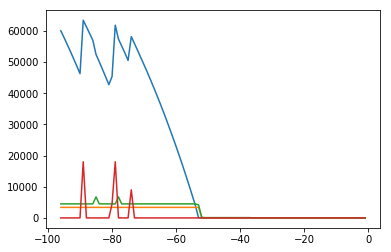

In [69]:
#df_card.groupby('SK_ID_PREV').MONTHS_BALANCE.count().sort_values()
tmp=df_card[df_card.SK_ID_PREV==1468118].sort_values(by='MONTHS_BALANCE')
plt.plot(tmp.MONTHS_BALANCE,tmp.AMT_BALANCE)
plt.plot(tmp.MONTHS_BALANCE,tmp.AMT_INST_MIN_REGULARITY)
plt.plot(tmp.MONTHS_BALANCE,tmp.AMT_PAYMENT_CURRENT)
plt.plot(tmp.MONTHS_BALANCE,tmp.AMT_DRAWINGS_CURRENT)


tmp['my_diff'] = tmp.AMT_DRAWINGS_CURRENT+tmp.AMT_INST_MIN_REGULARITY-tmp.AMT_PAYMENT_TOTAL_CURRENT
tmp['balance_diff'] = tmp.AMT_BALANCE.diff()

tmp[['AMT_PAYMENT_TOTAL_CURRENT','AMT_INST_MIN_REGULARITY','AMT_DRAWINGS_CURRENT','AMT_BALANCE','balance_diff','NAME_CONTRACT_STATUS']].head(20)

In [64]:
46258.965+18000+(3750-4500.0)

63508.965